# Proyecto 1
El Fondo de Población de las Naciones Unidas (UNFPA), en el marco de la Agenda 2030, busca 
aprovechar las opiniones ciudadanas para identificar problemáticas relacionadas con los 
Objetivos de Desarrollo Sostenible (ODS). En particular, se requiere un sistema capaz de analizar 
y clasificar textos en tres categorías:

- **ODS 1**: Fin de la pobrez
- **ODS 3**: Salud y bienestar
- **ODS 4**: Educación de calidad

El reto consiste en desarrollar un modelo de analítica de textos que reciba como entrada una 
opinión en lenguaje natural y prediga automáticamente a cuál ODS pertenece. Este modelo 
debe ser lo suficientemente robusto para manejar textos largos, con ruido (referencias, 
paréntesis, números) y en español.

## 1. Instalación e importanción de librerías.


In [1]:
!/usr/local/opt/python@3.13/bin/python3.13 -m pip install -U spacy
!/usr/local/opt/python@3.13/bin/python3.13 -m spacy download es_core_news_md


zsh:1: no such file or directory: /usr/local/opt/python@3.13/bin/python3.13
zsh:1: no such file or directory: /usr/local/opt/python@3.13/bin/python3.13


In [ ]:
# --- Instalación (mac) ---
# !python3 -m pip install -U nltk spacy scikit-learn matplotlib seaborn unidecode
# !python3 -m spacy download es_core_news_md
# !python3 -m pip install openpyxl
# python3 -m pip install openpyxl


# --- Imports base ---
import re, string, unicodedata
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
# Si quisieras stemming en español (no recomendado para el pipeline final):
# from nltk.stem import SnowballStemmer

import spacy
# Carga del modelo de spaCy en español 
nlp = spacy.load("es_core_news_md")

# Utilidad: solo úsalo DESPUÉS de lematizar si quieres una segunda versión sin acentos
import unidecode

# Sklearn: vectorización y modelos
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# NLTK data 
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import Counter

# --- Hugging Face / PyTorch (para fine-tuning BERT) ---
import torch
from datasets import Dataset
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    pipeline,
)

## 2. Perfilamiento y entendimiento de los datos.

En esta sección realizamos la **lectura** y un primer **análisis exploratorio** de los datos 
proporcionados para el proyecto. Contamos con dos archivos principales:

- Datos_proyecto.xlsx → dataset principal de opiniones ciudadanas con sus etiquetas ODS.  
- Datos de prueba_proyecto.xlsx → dataset de prueba para evaluar el modelo seleccionado.


### Carga de datos

In [3]:
# Lectura del dataset principal
data = pd.read_excel("Datos_proyecto.xlsx")

# Asignación a una nueva variable para trabajar
data_t = data.copy()

# Vista inicial
data_t.head()


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [4]:
# Información general: filas, columnas, tipos de datos
data_t.info()

# Valores nulos
print("\nValores nulos por columna:")
print(data_t.isnull().sum())

# Distribución de las etiquetas
print("\nDistribución de etiquetas (ODS):")
print(data_t['labels'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB

Valores nulos por columna:
textos    0
labels    0
dtype: int64

Distribución de etiquetas (ODS):
labels
4    1025
3     894
1     505
Name: count, dtype: int64


In [5]:
# Crear columna con longitud de cada texto (en palabras)
data_t['longitud'] = data_t['textos'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print("\nEstadísticas de la longitud de los textos:")
print(data_t['longitud'].describe())




Estadísticas de la longitud de los textos:
count    2424.000000
mean      107.924092
std        35.575349
min        41.000000
25%        81.000000
50%       102.000000
75%       129.000000
max       260.000000
Name: longitud, dtype: float64


/var/folders/rd/c8h4x4m10sb985f52mrcc5600000gn/T/ipykernel_39884/4150625362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=data_t, palette='Set2')


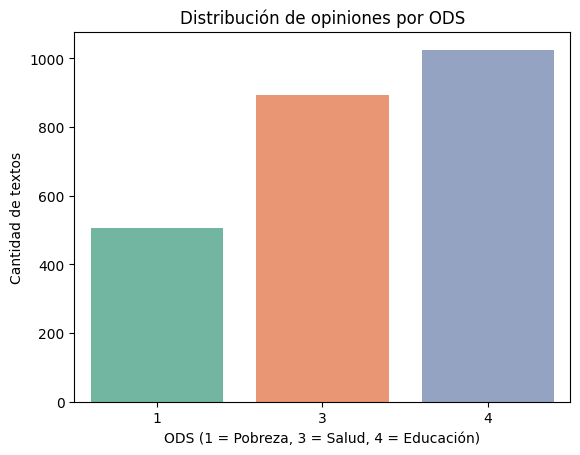

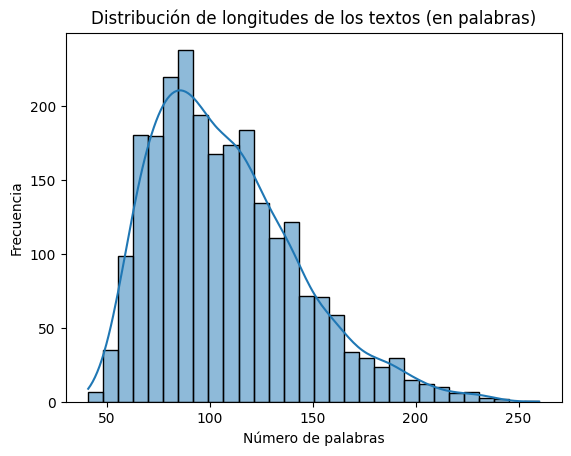

In [6]:

# Distribución de las etiquetas
sns.countplot(x='labels', data=data_t, palette='Set2')
plt.title("Distribución de opiniones por ODS")
plt.xlabel("ODS (1 = Pobreza, 3 = Salud, 4 = Educación)")
plt.ylabel("Cantidad de textos")
plt.show()

# Histograma de longitudes de texto
sns.histplot(data_t['longitud'], bins=30, kde=True)
plt.title("Distribución de longitudes de los textos (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()


## 3. Preparación de los datos
En este paso aplicamos un pipeline de limpieza en español:
- Normalización de texto
- Tokenización con NLTK (RegexpTokenizer, no requiere punkt)
- Eliminación de stopwords personalizadas
- Lematización con spaCy
- Generación de columnas procesadas


### 3.1 Definir stopwords y listas personalizadas
Qué hace:
- Crea una lista de palabras vacías en español y la adapta al dominio.  
- Quita conectores innecesarios (*además, sin embargo…*) y protege palabras críticas de ODS (*pobreza, salud, educación*).  

Por qué:
- Si eliminamos demasiado, el modelo pierde señal.  
- Si dejamos ruido académico, el modelo aprende cosas irrelevantes.  

Ejemplo: 
- Texto original: "La educación, sin embargo, debe mejorar"  
- Tras stopwords personalizadas: ["educación", "mejorar"]


In [7]:
# spaCy en español (usa "lg" si lo tienes)
nlp = spacy.load("es_core_news_md")

# Stopwords base español
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")
STOP_ES = set(stopwords.words("spanish"))

# Stopwords adicionales comunes en textos académicos
STOP_EXTRA = {
    "ademas","asimismo","sin","embargo","no","obstante","por","consiguiente",
    "asi","mismo","tambien","entre","otros","etc","respecto","dicho","misma",
    "mismo","mismas","mismos","puede","pueden","debe","deben","debido","cual",
    "cuales","cualquier","cada","dentro","fuera","segun","con","contra","hacia",
    "desde","sobre","tras","mediante"
}

# Palabras que NO debemos eliminar (clave para ODS)
ALLOWLIST_ODS = {
    "ods","pobreza","salud","educación","educacion","docente","docentes","escuela","escolar",
    "universidad","primaria","secundaria","matrícula","matricula","hospital","atención","atencion",
    "paciente","mental","prom","prem","epr","currículo","curriculo","formación","formacion"
}

# Stopwords finales
STOP_CUSTOM = (STOP_ES | STOP_EXTRA) - ALLOWLIST_ODS


### 3.2 Funciones de limpieza (con RegexpTokenizer)

a) normalize_text  
- Qué hace: convierte a minúsculas, elimina URLs, citas (OCDE 2013), paréntesis y comillas raras.  
- Por qué: evita que el modelo confunda tokens inútiles con información relevante.  
- Ejemplo: "Informe de la OCDE (2013)" → "informe de la ocde"

b) tokenize con RegexpTokenizer 
- Qué hace: divide en palabras usando solo caracteres alfabéticos.  
- Por qué: quita números/puntuación que no ayudan.  
- Ejemplo: "la educación en 2013 fue clave" → ["la","educación","en","fue","clave"]

c) remove_stopwords
- Qué hace: borra stopwords pero conserva palabras críticas (ALLOWLIST).  
- Por qué: filtra ruido pero protege la semántica de ODS.  
- Ejemplo: ["la","educación","en","fue","clave"] → ["educación","clave"]

d) lemmatize_es con spaCy  
- Qué hace: reduce palabras a su forma mas basica.  
- Por qué: unifica variaciones (*estudiantes → estudiante, aprendiendo → aprender*).  
- Ejemplo: ["estudiantes","aprendiendo","docentes"] → ["estudiante","aprender","docente"]

e) clean_pipeline 
- Qué hace: une todos los pasos en orden → normalizar → tokenizar → stopwords → lematizar.  
- Por qué: garantiza consistencia en todo el dataset.  
- Ejemplo: "Los estudiantes estaban aprendiendo en la escuela" → ["estudiante","aprender","escuela"]


In [8]:


# Tokenizador sin punkt
_tokenizer = RegexpTokenizer(r"\w+")

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = re.sub(r'(https?://\S+)|(\S+@\S+)', ' ', t)   # URLs y correos
    t = re.sub(r'\([^)]*\d{2,4}[^)]*\)', ' ', t)      # referencias (OCDE, 2013)
    t = re.sub(r'[“”"«»´`]', ' ', t)                  # comillas raras
    t = re.sub(r'\s+', ' ', t)                        # espacios múltiples
    return t.strip()

def tokenize(text: str):
    toks = _tokenizer.tokenize(str(text or ""))
    return [t for t in toks if t.isalpha()]

def remove_stopwords(tokens):
    return [t for t in tokens if (t not in STOP_CUSTOM) or (t in ALLOWLIST_ODS)]

def lemmatize_es(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = [t.lemma_ for t in doc if t.is_alpha]
    lemmas = [l for l in lemmas if (l not in STOP_CUSTOM) or (l in ALLOWLIST_ODS)]
    return lemmas

def clean_pipeline(text: str):
    t = normalize_text(text)
    toks = tokenize(t)
    toks = remove_stopwords(toks)
    lemmas = lemmatize_es(toks)
    return lemmas


### 3.3 Aplicar el pipeline al dataset

Qué hace: 
- Aplica clean_pipeline a cada fila de la columna textos.  
- Genera columnas nuevas:  
  - tokens: lista de palabras limpias.  
  - texto_limpio: texto unido (para vectorización).  
  - longitud_tokens: tamaño del texto procesado.  

Por qué: 
- Necesitamos una vista de tokens para nosotros, una vista lista para modelos (texto_limpio) y una métrica de control (longitud_tokens).  

Ejemplo: 
- Entrada: "Los estudiantes estaban aprendiendo en la escuela" 
- Salida:  
  - tokens → ["estudiante","aprender","escuela"]`  
  - texto_limpio → "estudiante aprender escuela"`  
  - longitud_tokens → 3


In [9]:
# Aplicar pipeline
data_t["tokens"] = data_t["textos"].apply(clean_pipeline)

# Columnas auxiliares
data_t["texto_limpio"] = data_t["tokens"].apply(lambda xs: " ".join(xs))
data_t["longitud_tokens"] = data_t["tokens"].apply(len)

# Vista previa
data_t[["textos","labels","texto_limpio","longitud_tokens"]].head()


,textos,labels,texto_limpio,longitud_tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,aprendizaje educación considerar sinónimo esco...,25
1,Para los niños más pequeños (bebés y niños peq...,4,niño pequeño bebé niño pequeño capacitación es...,39
2,"Además, la formación de especialistas en medic...",3,además formación especialista medicina general...,50
3,En los países de la OCDE se tiende a pasar de ...,4,país ocde tender pasar curso obligatorio optat...,55
4,Este grupo se centró en las personas que padec...,3,grupo centrar persona padecer trastorno mental...,52


### 3.4 Chequeos básicos

Qué hace: 
- Muestra info() y valores nulos → detecta problemas de integridad.  
- Cuenta las etiquetas (labels) → revisa desbalance.  
- Grafica histograma de longitudes → detecta outliers o textos vacíos.  

Por qué: 
- Si tenemos muchos vacíos, el modelo se entrena mal.  
- Si hay mucho desbalance (ej. más ODS 4 que ODS 1), necesitaremos técnicas de balanceo o métricas ajustadas.  

Ejemplo:
- Histograma muestra que la mayoría de textos tienen entre 30–100 tokens.  
- Distribución de etiquetas muestra más ODS 4 que ODS 1/3.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   textos           2424 non-null   object
 1   labels           2424 non-null   int64 
 2   longitud         2424 non-null   int64 
 3   tokens           2424 non-null   object
 4   texto_limpio     2424 non-null   object
 5   longitud_tokens  2424 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 113.8+ KB
None

Valores nulos por columna:
textos             0
labels             0
longitud           0
tokens             0
texto_limpio       0
longitud_tokens    0
dtype: int64

Distribución de etiquetas (ODS):
labels
4    1025
3     894
1     505
Name: count, dtype: int64


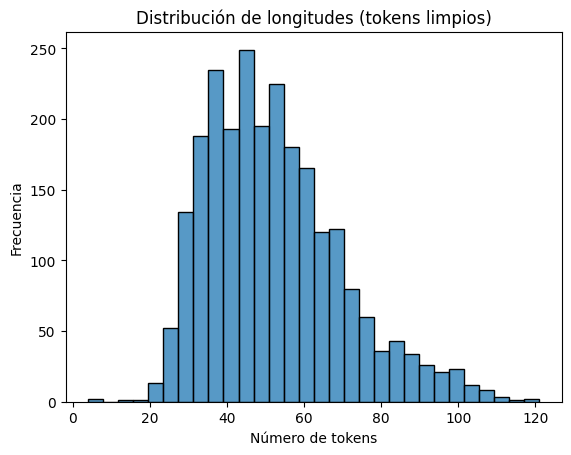

In [10]:
# Información del dataset
print(data_t.info())

# Valores nulos
print("\nValores nulos por columna:")
print(data_t.isnull().sum())

# Distribución de clases
print("\nDistribución de etiquetas (ODS):")
print(data_t['labels'].value_counts())

# Distribución de longitudes
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data_t["longitud_tokens"], bins=30, kde=False)
plt.title("Distribución de longitudes (tokens limpios)")
plt.xlabel("Número de tokens")
plt.ylabel("Frecuencia")
plt.show()


### 3.5 Explorar n-gramas clave

Qué hace: 
- Extrae frases frecuentes por clase.  

Por qué:
- Nos ayuda a saber que conceptos aparecen más en cada ODS.    

In [11]:

def top_ngrams(texts, n=2, k=5):
    counts = Counter()
    for t in texts:
        toks = t.split()
        ngs = zip(*[toks[i:] for i in range(n)])
        counts.update([" ".join(g) for g in ngs])
    return counts.most_common(k)

for etiqueta in sorted(data_t["labels"].unique()):
    subset = data_t.loc[data_t["labels"]==etiqueta, "texto_limpio"].tolist()
    print(f"\nTop bigramas ODS {etiqueta}:")
    for g,c in top_ngrams(subset, n=2, k=5):
        print(f"  {g}  ({c})")



Top bigramas ODS 1:
  pobreza infantil  (95)
  tasa pobrezo  (80)
  pobreza extremo  (52)
  protección social  (47)
  reducción pobreza  (46)

Top bigramas ODS 3:
  salud mental  (227)
  atención primario  (206)
  atención salud  (94)
  sistema salud  (84)
  servicio salud  (81)

Top bigramas ODS 4:
  sistema educativo  (116)
  educación superior  (107)
  secundario superior  (80)
  educación secundario  (67)
  educación terciario  (62)


## 4. MODELO: Naive Bayes

por: Ana Cristina Rodríguez

El Naive Bayes Multinomial (MNB) es un algoritmo de clasificación probabilística basado en el Teorema de Bayes.
Su idea central es calcular la probabilidad de que un texto pertenezca a una clase (por ejemplo, ODS 1, ODS 3 u ODS 4), dadas las palabras que contiene.

Al ser multinomial está especialmente diseñado para trabajar con frecuencias de palabras o representaciones TF-IDF, la cual es una técnica de representación de texto que transforma documentos en vectores numéricos, resaltando las palabras más importantes y discriminativas de cada texto.

No obstante, la mayor deventaja de este algorítmo es que no capta relaciones semánticas complejas entre palabras.

### 4.1. Imports y configuraciones:

In [12]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [13]:
# Config
TEXT_COL = 'texto_limpio' if 'texto_limpio' in data_t.columns else 'textos'
LABEL_COL = 'labels'  

In [14]:
# DataFrame base para modelar (sin nulos ni vacíos)
df = data_t[[TEXT_COL, LABEL_COL]].copy()
df.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
df = df[df[TEXT_COL].str.len() > 0].copy()

In [15]:
print(df[[TEXT_COL, LABEL_COL]].head())
df[LABEL_COL].value_counts()

                                        texto_limpio  labels
0  aprendizaje educación considerar sinónimo esco...       4
1  niño pequeño bebé niño pequeño capacitación es...       4
2  además formación especialista medicina general...       3
3  país ocde tender pasar curso obligatorio optat...       4
4  grupo centrar persona padecer trastorno mental...       3


labels
4    1025
3     894
1     505
Name: count, dtype: int64

### 4.2. Particiones
División de edtaset en train (70%) ,validacion (15%) y test (15%) manteniendo la misma proporción de clases en cada subconjunto. 

In [16]:
X = df[TEXT_COL].values
y = df[LABEL_COL].values

# 15% test fijo
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=3301
)
# aprox. 15% valid del total
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=3301
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")


Train: 1696 | Val: 364 | Test: 364


### 4.3. Entrenamiento y optimización Naive Bayes

Pipeline TF-IDF + MultinomialNB y búsqueda por F1-macro

- Probamos analyzer en palabras y en caracteres (char_wb ayuda con typos).

- Probamos n-gramas (1,1) y (1,2), min_df, max_df, sublinear_tf y alpha.

In [17]:

#Definición del pipeline 
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='unicode')),
    ('clf', MultinomialNB())
])

# Hiperparámetros 
param_grid = {
    'tfidf__analyzer':    ['word', 'char_wb'],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df':      [1, 2, 5],
    'tfidf__max_df':      [0.9, 1.0],
    'tfidf__sublinear_tf':[True, False],
    'clf__alpha':         [0.1, 0.5, 1.0]
}

# Pesos por clase para atenuar desbalance 
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
cw_map = dict(zip(classes, class_weights))
sample_weight_train = np.array([cw_map[yi] for yi in y_train])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3301)

grid_nb = GridSearchCV(
    estimator=pipe_nb,
    param_grid=param_grid,
    scoring='f1_macro',     
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Con pesos (pasan al paso clf del pipeline)
grid_nb.fit(X_train, y_train, clf__sample_weight=sample_weight_train)

print("Mejor configuración:", grid_nb.best_params_)
print("Mejor F1-macro (CV):", round(grid_nb.best_score_, 4))
best_nb = grid_nb.best_estimator_


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Mejor configuración: {'clf__alpha': 0.1, 'tfidf__analyzer': 'word', 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': False}
Mejor F1-macro (CV): 0.9674


Se tenían 144 posibles combinaciones posibles de los parámetros. 
Cada combinación se probó 5 veces con validación cruzada estratificada. 
Dando un total de 720 entrenamientos en total. 

Los resultados muestran que palabras (uni+bi), sin suavizado de frecuencias, alpha bajo y filtrando palabras muy comunes dan el mejor rendimiento.

### 4.4. Evaluación en Validación 

- Precision: Confiabilidad al clasificar en cierta clase.
- Recall: Qué tanto logra encontrar el modelo de los casos reales de una clase.
- F1-score: Equilibrio entre precision y recall.

- Matriz de confusion: muestra cuántas predicciones se clasifican correctamente y en dónde se equivoca el modelo

== Validación ==
              precision    recall  f1-score   support

           1      0.912     0.961     0.936        76
           3      1.000     0.940     0.969       134
           4      0.956     0.981     0.968       154

    accuracy                          0.962       364
   macro avg      0.956     0.960     0.958       364
weighted avg      0.963     0.962     0.962       364



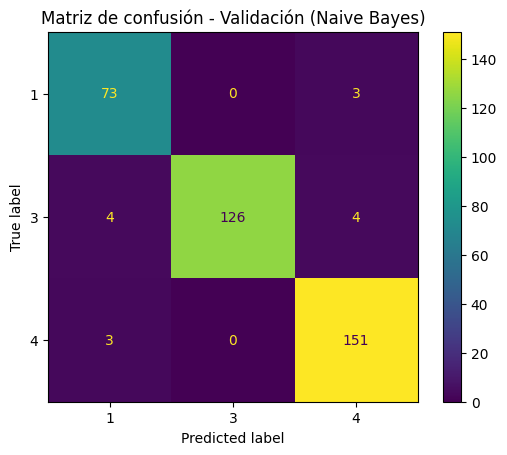

In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_val_pred = best_nb.predict(X_val)
print("== Validación ==")
print(classification_report(y_val, y_val_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title("Matriz de confusión - Validación (Naive Bayes)")
plt.show()


El modelo Naive Bayes, optimizado con TF-IDF (uni+bi-gramas), alcanzó un 96.2% de exactitud y un F1-macro de 0.958 en validación. Los resultados son consistentes en todas las clases (ODS1, ODS3 y ODS4), lo que evidencia que el modelo es robusto y generaliza bien sin favorecer a una categoría en particular.

### 4.5. Reentrenamiento 
Reentrenamiento del modelo usando más datos (train+val) una vez elegidos los mejores hiperparámetros. 

== Test (métricas finales) ==
              precision    recall  f1-score   support

           1      0.973     0.947     0.960        76
           3      0.970     0.955     0.962       134
           4      0.968     0.994     0.981       154

    accuracy                          0.970       364
   macro avg      0.970     0.965     0.968       364
weighted avg      0.970     0.970     0.970       364

F1-macro (test): 0.9677


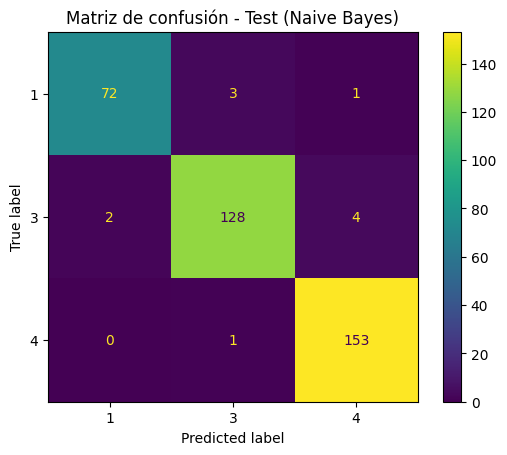

In [19]:
from sklearn.metrics import f1_score

# Recalcular sample_weight para train+val 
y_train_all = np.concatenate([y_train, y_val])
X_train_all = np.concatenate([X_train, X_val])

classes_all = np.unique(y_train_all)
cw_all = compute_class_weight('balanced', classes=classes_all, y=y_train_all)
cw_map_all = dict(zip(classes_all, cw_all))
sw_trainval = np.array([cw_map_all[yi] for yi in y_train_all])

best_nb.fit(X_train_all, y_train_all, clf__sample_weight=sw_trainval)

y_test_pred  = best_nb.predict(X_test)
y_test_proba = best_nb.predict_proba(X_test)  

print("== Test (métricas finales) ==")
print(classification_report(y_test, y_test_pred, digits=3))
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
print("F1-macro (test):", round(macro_f1, 4))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Matriz de confusión - Test (Naive Bayes)")
plt.show()


Los resultados muestran una exactitud (accuracy) de 0.970, es decir que el 97% de los textos son clasificados correctamente en el conjunto de prueba. 

Para ODS1 (pobreza) alcanzó una precisión de 0.973 y un F1 de 0.960, aunque con un recall ligeramente menor (0.947), lo que indica que en algunos casos no logró identificar todos los textos de esta categoría. En ODS3 (salud) obtuvo valores equilibrados de precisión (0.970) y recall (0.955), con un F1 de 0.962, reflejando un buen balance entre aciertos y cobertura. Finalmente, en ODS4 (educación) el modelo alcanzó su mejor desempeño, con una precisión de 0.968, un recall muy alto de 0.994 y un F1 de 0.981, lo que evidencia que casi todos los textos relacionados con educación fueron correctamente clasificados.

### 4.6. Resultados: Extracción de términos populares en cada clase
A continuación, se extraen y muestran las palabras más relevantes que Naive Bayes usa para clasificar cada ODS.

In [20]:
vec: TfidfVectorizer = best_nb.named_steps['tfidf']
clf: MultinomialNB    = best_nb.named_steps['clf']
feature_names = np.array(vec.get_feature_names_out())

for idx, cls in enumerate(clf.classes_):
    top_idx = np.argsort(clf.feature_log_prob_[idx])[::-1][:20]
    print(f"\nTop términos indicativos para clase {cls}:")
    print(feature_names[top_idx])



Top términos indicativos para clase 1:
['pobreza' 'ingreso' 'pobre' 'hogar' 'pobrezo' 'pais' 'nino' 'tasa'
 'social' 'infantil' 'privacion' 'persona' 'pobreza infantil'
 'crecimiento' 'vivir' 'tasa pobrezo' 'mayor' 'familia' 'umbral' 'medida']

Top términos indicativos para clase 3:
['salud' 'atencion' 'medico' 'servicio' 'mental' 'paciente' 'sanitario'
 'enfermedad' 'salud mental' 'pais' 'sistema' 'atencion primario'
 'primario' 'persona' 'hospital' 'calidad' 'tratamiento' 'bajo' 'ano'
 'mortalidad']

Top términos indicativos para clase 4:
['escuela' 'educacion' 'docente' 'estudiant' 'escolar' 'aprendizaje'
 'evaluacion' 'educativo' 'alumno' 'ano' 'programa' 'profesor'
 'profesional' 'nivel' 'estudiante' 'superior' 'sistema' 'el' 'habilidad'
 'formacion']


### 4.7.Resultados: Visualización de mejores combinaciones de hiperparámetros
Este bloque te da una tabla ordenada con las 10 mejores combinaciones de hiperparámetros y su desempeño en validación cruzada. Esto permite tomar la mejor decisión basada en datos para seleccionar el mejor modelo.

In [21]:
cv_results = pd.DataFrame(grid_nb.cv_results_)
cols = ['mean_test_score','std_test_score','param_tfidf__analyzer',
        'param_tfidf__ngram_range','param_tfidf__min_df','param_tfidf__max_df',
        'param_tfidf__sublinear_tf','param_clf__alpha','rank_test_score']
cv_results[cols].sort_values('rank_test_score').head(10)


,mean_test_score,std_test_score,param_tfidf__analyzer,param_tfidf__ngram_range,param_tfidf__min_df,param_tfidf__max_df,param_tfidf__sublinear_tf,param_clf__alpha,rank_test_score
3,0.967357,0.014181,word,"(1, 2)",1,0.9,False,0.1,1
15,0.967357,0.014181,word,"(1, 2)",1,1.0,False,0.1,1
2,0.967047,0.015259,word,"(1, 2)",1,0.9,True,0.1,3
14,0.967047,0.015259,word,"(1, 2)",1,1.0,True,0.1,3
103,0.965205,0.009686,word,"(1, 2)",2,0.9,False,1.0,5
115,0.965205,0.009686,word,"(1, 2)",2,1.0,False,1.0,5
19,0.965175,0.013456,word,"(1, 2)",2,1.0,False,0.1,7
7,0.965175,0.013456,word,"(1, 2)",2,0.9,False,0.1,7
67,0.964622,0.012367,word,"(1, 2)",2,1.0,False,0.5,9
55,0.964622,0.012367,word,"(1, 2)",2,0.9,False,0.5,9


El ajuste de hiperparámetros mediante GridSearchCV mostró que las mejores configuraciones para Naive Bayes se alcanzan con una representación TF-IDF basada en palabras (unigramas y bigramas), con un suavizado bajo (α=0.1), min_df=1, max_df=0.9–1.0 y sin aplicar sublinear TF. Esta combinación obtuvo un F1-macro promedio de 0.967 en validación cruzada, con una desviación estándar cercana a 0.014, lo que refleja un desempeño alto y estable. 

Con esto en mente, el uso de bigramas y un suavizado bajo permiten la mejor combinación para maximizar la capacidad de discriminación entre las clases. 

## 5. MODELO: Vectorización + Modelo lineal 
Por: Juliana Durán

En este punto transformamos los textos ya limpios en representaciones numéricas (vectores) y entrenamos un primer modelo de clasificación para predecir el ODS (1, 3 o 4).


### 5.1 Separar datos en train/test (con estratificación)

Por qué: necesitamos un conjunto para entrenar y otro para evaluar de forma honesta.

Estratificación: mantiene la proporción de ODS (1/3/4) igual en train y test (importante porque está desbalanceado).

In [22]:
from sklearn.model_selection import train_test_split

X = data_t["texto_limpio"]   
y = data_t["labels"]         

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 80%/20%
    random_state=42,
    stratify=y               # mantiene proporciones por clase
)

len(X_train), len(X_test), y_train.value_counts(normalize=True).round(3), y_test.value_counts(normalize=True).round(3)


(1939,
 485,
 labels
 4    0.423
 3    0.369
 1    0.208
 Name: proportion, dtype: float64,
 labels
 4    0.423
 3    0.369
 1    0.208
 Name: proportion, dtype: float64)

### 5.2 Vectorizar con TF-IDF

Qué es: convierte cada texto en un vector de pesos (importancia de cada término).

Explicacion mas larga: 
Se utilizó TF-IDF (Term Frequency – Inverse Document Frequency) para transformar los textos en vectores numéricos. TF mide cuántas veces aparece una palabra en un documento. IDF penaliza las palabras muy comunes en el corpus. Así, palabras distintivas como “pobreza” o “universidad” reciben más peso que términos generales como “el” o “de”. Además, se emplearon: Unigramas → palabras individuales (“educación”). Bigramas → pares de palabras consecutivas (“educación superior”). Esto permite capturar tanto términos aislados como combinaciones frecuentes de palabras.


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_features=5000,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)  # aprende vocabulario en TRAIN
X_test_tfidf  = tfidf.transform(X_test)       # aplica exactamente el mismo vocabulario a TEST

X_train_tfidf.shape, X_test_tfidf.shape


((1939, 5000), (485, 5000))

### 5.3 Entrenar el modelo lineal: LinearSVC

Por qué este modelo:

- Es un SVM lineal: funciona muy bien con TF-IDF.

- class_weight="balanced" compensa el desbalance (da más peso a clases minoritarias).

- Rápido y estable en texto.

Para el modelo base se empleó un clasificador LinearSVC con el parámetro C=1.0 (valor por defecto), lo que permitió establecer una línea base de desempeño antes de realizar la optimización de hiperparámetros.

In [24]:
from sklearn.svm import LinearSVC

clf = LinearSVC(
    C=1.0,   
    class_weight="balanced",
    random_state=42
)

clf.fit(X_train_tfidf, y_train)   # aprende fronteras lineales por clase (uno-vs-rest)
y_pred = clf.predict(X_test_tfidf)


### 5.4 Evaluación (métricas y matriz de confusión)

Qué miramos:

- classification_report con promedio macro (no favorece a la clase grande).

- Matriz de confusión para ver qué ODS se confunden.

              precision    recall  f1-score   support

           1      0.960     0.941     0.950       101
           3      0.967     0.972     0.969       179
           4      0.976     0.980     0.978       205

    accuracy                          0.969       485
   macro avg      0.967     0.964     0.966       485
weighted avg      0.969     0.969     0.969       485



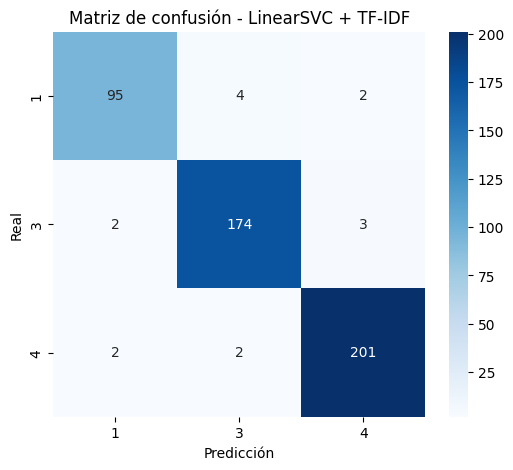

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=[1,3,4])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1,3,4], yticklabels=[1,3,4])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - LinearSVC + TF-IDF")
plt.show()


El modelo LinearSVC con representación TF-IDF  alcanzó un desempeño sobresaliente en la tarea de clasificación de textos en los Objetivos de Desarrollo Sostenible (ODS).

En términos de métricas globales, se obtuvo una exactitud (accuracy) del 96.9%, con un F1 macro de 0.966 y un F1 ponderado de 0.969. Estos valores reflejan un rendimiento consistente entre clases, sin que el modelo presente sesgo hacia la clase mayoritaria.

El desglose por clase muestra valores de F1 cercanos a 0.97 en todos los ODS considerados:

- ODS 1 (pobreza): F1 = 0.950

- ODS 3 (salud): F1 = 0.969

- ODS 4 (educación): F1 = 0.978

La matriz de confusión confirma la solidez del modelo, ya que más del 97% de los textos fueron clasificados correctamente. Los errores detectados corresponden a confusiones puntuales entre ODS 1 y ODS 3, lo cual resulta comprensible dada la cercanía temática entre pobreza y salud en contextos sociales y políticos.

En conclusión, el modelo LinearSVC + TF-IDF constituye una solución efectiva y balanceada para la clasificación automática de textos en los ODS, con un rendimiento altamente competitivo y confiable para aplicaciones prácticas en el análisis de políticas y documentos relacionados con el desarrollo sostenible

### 5.5 ¿Qué palabras empujan cada clase? (interpretabilidad)

Por qué: al ser un modelo lineal, cada término tiene un peso (coeficiente).

Pesos grandes y positivos para una clase = términos que la favorecen.

In [26]:
import numpy as np

feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_               
classes = clf.classes_          

def top_terms_per_class(k=5):
    for idx, c in enumerate(classes):
        topk = np.argsort(coefs[idx])[-k:][::-1]
        terms = [feature_names[i] for i in topk]
        weights = [coefs[idx][i] for i in topk]
        print(f"\nTop términos para ODS {c}:")
        for t, w in zip(terms, weights):
            print(f"  {t:25s} {w:.3f}")

top_terms_per_class(k=5)



Top términos para ODS 1:
  pobreza                   4.596
  pobre                     2.692
  pobrezo                   2.428
  hogar                     1.655
  privación                 1.647

Top términos para ODS 3:
  salud                     3.796
  médico                    2.085
  atención                  1.912
  sanitario                 1.850
  enfermedad                1.810

Top términos para ODS 4:
  educación                 3.195
  escuela                   2.545
  educativo                 2.198
  estudiant                 1.861
  docente                   1.843


### 5.6 Pipeline integrado + GridSearch rápido

Por qué: el Pipeline asegura que vectorización y modelo queden acoplados (reproducible). Además puedes afinar el hiperparámetro C (fuerza de regularización).

Se exploraron otros valores de C (0.5, 1.0, 2.0) mediante validación cruzada. El mejor desempeño se obtuvo con C=0.5, lo que permitió ampliar ligeramente el margen del clasificador y mejorar la generalización del modelo

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_features=5000,
        sublinear_tf=True
    )),
    ("clf", LinearSVC(
        # no tenemos c para poder ajustarlo
        class_weight="balanced", 
        random_state=42))
])

#Definimos un diccionario de cs a probar.
param_grid = {
    "clf__C": [0.5, 1.0, 2.0]  # probando distintos valores de c
}

# me ayuda a buscar el mejor c
# es como un for anidado que prueba todas las combinaciones

grid = GridSearchCV(
    pipe, param_grid,
    scoring="f1_macro",    # métrica que trata todas las clases por igual
    #f1 macro es nuestra metrica de evalucacion
    cv=5,  # división en 5 partes, la 5 es la que valida
    n_jobs=-1  # usa todos los núcleos disponibles para acelerar el proceso
)
grid.fit(X_train, y_train)

print("Mejor C:", grid.best_params_)
print("Mejor F1_macro:", round(grid.best_score_, 3))

# Evaluación final en TEST con el mejor pipeline
best_pipe = grid.best_estimator_
y_pred_gs = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred_gs, digits=3))


Mejor C: {'clf__C': 0.5}
Mejor F1_macro: 0.971
              precision    recall  f1-score   support

           1      0.960     0.941     0.950       101
           3      0.967     0.972     0.969       179
           4      0.976     0.980     0.978       205

    accuracy                          0.969       485
   macro avg      0.967     0.964     0.966       485
weighted avg      0.969     0.969     0.969       485



## 6. Fine-tuning BERT (Hugging Face)

> Clasificación de secuencias para ODS 1, 3 y 4 con dos variantes de texto:
- Texto crudo (sin limpieza)
- Texto limpio (pipeline spaCy/NTLK del cuaderno)

Usamos Apple Silicon (MPS) si está disponible. Se reaprovechan `data_t`, `texto_limpio` y `labels`. Además, los modelos y resultados se guardan en `./hf_models/`. 

In [ ]:
# Dispositivo (MPS si existe)
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

In [ ]:
# Preparar DataFrame base con columnas esperadas
# Usamos data_t ya cargado y procesado arriba.
df = data_t.copy()
assert 'labels' in df.columns, "No encontramos la columna 'labels' en data_t"
text_col = 'textos' if 'textos' in df.columns else None
clean_col = 'texto_limpio' if 'texto_limpio' in df.columns else None
assert text_col is not None, "No encontramos la columna de texto crudo ('textos')"
assert clean_col is not None, "No encontramos la columna de texto limpio ('texto_limpio')"

# Mapeo de etiquetas a ids ordenados
unique_labels = sorted(df['labels'].unique())
label2id = {v:i for i,v in enumerate(unique_labels)}
id2label = {i:str(v) for v,i in label2id.items()}
df['label_id'] = df['labels'].map(label2id)
print('label2id:', label2id)

In [ ]:
# Tokenizador y preprocesamiento de entrada para BERT
MODEL_NAME = "bert-base-multilingual-cased"  # alternativa: dccuchile/bert-base-spanish-wwm-cased
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

max_length = 256
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=False, max_length=max_length)

print("Tokenizando datasets (raw)...")
hf_train_raw = hf_train_raw.map(preprocess_function, batched=True)
hf_test_raw  = hf_test_raw.map(preprocess_function, batched=True)

print("Tokenizando datasets (clean)...")
hf_train_clean = hf_train_clean.map(preprocess_function, batched=True)
hf_test_clean  = hf_test_clean.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')
    return {**acc, 'f1_weighted': f1['f1']}

In [ ]:
# Tokenizador y preprocesamiento de entrada para BERT
MODEL_NAME = "bert-base-multilingual-cased"  # alternativa: dccuchile/bert-base-spanish-wwm-cased
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

max_length = 256
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=False, max_length=max_length)

print("Tokenizando datasets (raw)...")
hf_train_raw = hf_train_raw.map(preprocess_function, batched=True)
hf_test_raw  = hf_test_raw.map(preprocess_function, batched=True)

print("Tokenizando datasets (clean)...")
hf_train_clean = hf_train_clean.map(preprocess_function, batched=True)
hf_test_clean  = hf_test_clean.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average='weighted')
    return {**acc, 'f1_weighted': f1['f1']}

In [ ]:
# Función de entrenamiento/evaluación con Trainer
def run_experiment(train_dataset, eval_dataset, experiment_name, num_train_epochs=3, per_device_batch=8):
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )
    model.to(device)  # explícito en MPS
    output_dir = f"./hf_models/{experiment_name}"
    args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=per_device_batch,
        per_device_eval_batch_size=per_device_batch,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_weighted',
        greater_is_better=True,
        fp16=False,
        push_to_hub=False,
        report_to=[],
        logging_steps=50,
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    print(f"Entrenando experimento: {experiment_name}")
    trainer.train()
    print("Evaluando…")
    metrics = trainer.evaluate(eval_dataset=eval_dataset)
    print(metrics)
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    return metrics

In [ ]:
# Ejecutar experimentos: texto crudo vs texto limpio
import os
os.makedirs('./hf_models', exist_ok=True)

print("=== Experimento 1: RAW ===")
metrics_raw = run_experiment(hf_train_raw, hf_test_raw, experiment_name='bert_raw', num_train_epochs=3, per_device_batch=8)

print("=== Experimento 2: CLEAN ===")
metrics_clean = run_experiment(hf_train_clean, hf_test_clean, experiment_name='bert_clean', num_train_epochs=3, per_device_batch=8)

print("Resultados RAW:\n", metrics_raw)
print("Resultados CLEAN:\n", metrics_clean)

In [ ]:
# Inferencia rápida con el mejor modelo (ajusta ruta si cambias preferencia)
best_model_dir = './hf_models/bert_clean'
from pathlib import Path
if Path(best_model_dir).exists():
    clf_pipe = pipeline('text-classification', model=best_model_dir, tokenizer=best_model_dir, device=0 if str(device).startswith('cuda') else -1)
    ejemplos = [
        "Necesitamos mejorar el acceso a la educación básica en zonas rurales.",
        "Proyecto para construir clínicas y mejorar salud materna.",
        "Programas de transferencia monetaria para reducir la pobreza extrema.",
    ]
    print(clf_pipe(ejemplos))
else:
    print(f"No se encontró el directorio de modelo: {best_model_dir}")

# Final

| Modelo                 | Accuracy | F1 macro | Observaciones principales |
|-------------------------|----------|----------|---------------------------|
| **LinearSVC (TF-IDF)**  0.969    | 0.966    | Buen rendimiento, balanceado entre ODS 1, 3 y 4. Mejor C=0.5. |
| Naive Bayes                   |     0.970     |      0.968                     | Rendimiento muy bueno y estable. Bigramas y α=0.1 fueron clave. ODS1 tiene un recall ligeramente menor al resto al dejar unos falsos negativos. 
| Modelo de Mesa                  |          |                           |
